In [1]:
from wmi_backend_grid import *
from wmi_decompositions import *

import numpy as np

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import *
from util import *

# Single Trotter step

### Reference Hamiltonian

In [2]:
u = 1
t = 1
delta_t = 1
n = 1

In [3]:
lattice_size = (2,2)
Nx, Ny = lattice_size
num_sites = Nx*Ny

In [4]:
from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
from qiskit.circuit import Parameter

# 1↑ 2↑ 3↑ 4↑ 1↓ 2↓ 3↓ 4↓

# interaction term
A = 1/2*(I-Z)
H1 = (A^I^I^I^A^I^I^I) + (I^A^I^I^I^A^I^I) + (I^I^A^I^I^I^A^I) + (I^I^I^A^I^I^I^A)

# hopping term
H2 = -2*t*(
            (X^I^X^I^I^I^I^I) + (Y^I^Y^I^I^I^I^I)
            +(I^X^I^X^I^I^I^I) + (I^Y^I^Y^I^I^I^I)
            +(I^I^I^I^X^X^I^I) + (I^I^I^I^Y^Y^I^I)
            +(I^I^I^I^I^I^X^X) + (I^I^I^I^I^I^Y^Y)

            +(X^X^I^I^Z^Z^I^I) + (Y^Y^I^I^Z^Z^I^I)
            +(I^I^X^X^I^I^Z^Z) + (I^I^Y^Y^I^I^Z^Z)
            +(Z^I^Z^I^X^I^X^I) + (Z^I^Z^I^Y^I^Y^I)
            +(I^Z^I^Z^I^X^I^X) + (I^Z^I^Z^I^Y^I^Y)
            )

hamiltonian = H1 + H2
# evolution operator
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()
# into circuit
num_time_slices = n
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter',
                    reps=num_time_slices).convert(evolution_op)

C:\Users\thilo\AppData\Local\Temp\ipykernel_8408\3259680009.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
C:\Users\thilo\AppData\Local\Temp\ipykernel_8408\3259680009.py:29: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


In [5]:
circuit = trotterized_op.to_circuit()
param_bind = {
    evo_time: 1,
}
#ref_circ = trotterized_op.bind_parameters(param_bind).eval().to_circuit_op().to_circuit()
ref_matrix = trotterized_op.bind_parameters(param_bind).eval().to_matrix()

### 2D Trotter

In [6]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
trotter_circuit = QuantumCircuit(spin_up, spin_down)

In [7]:
# onsite interaction
lam = -u*delta_t
for i in range(num_sites):
    trotter_circuit.cp(lam, spin_up[i], spin_down[i])


trotter_circuit.barrier(spin_up, spin_down)


theta = 8*t*delta_t
eta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    trotter_circuit.append(ParamISwap(theta, eta), hop)

trotter_circuit.barrier(spin_up, spin_down)

swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    trotter_circuit.append(fSwap(), swap)


trotter_circuit.barrier(spin_up, spin_down)


theta = 8*t*delta_t
eta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    trotter_circuit.append(ParamISwap(theta, eta), hop)

trotter_circuit.barrier(spin_up, spin_down)

# swap back
swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    trotter_circuit.append(fSwap(), swap)

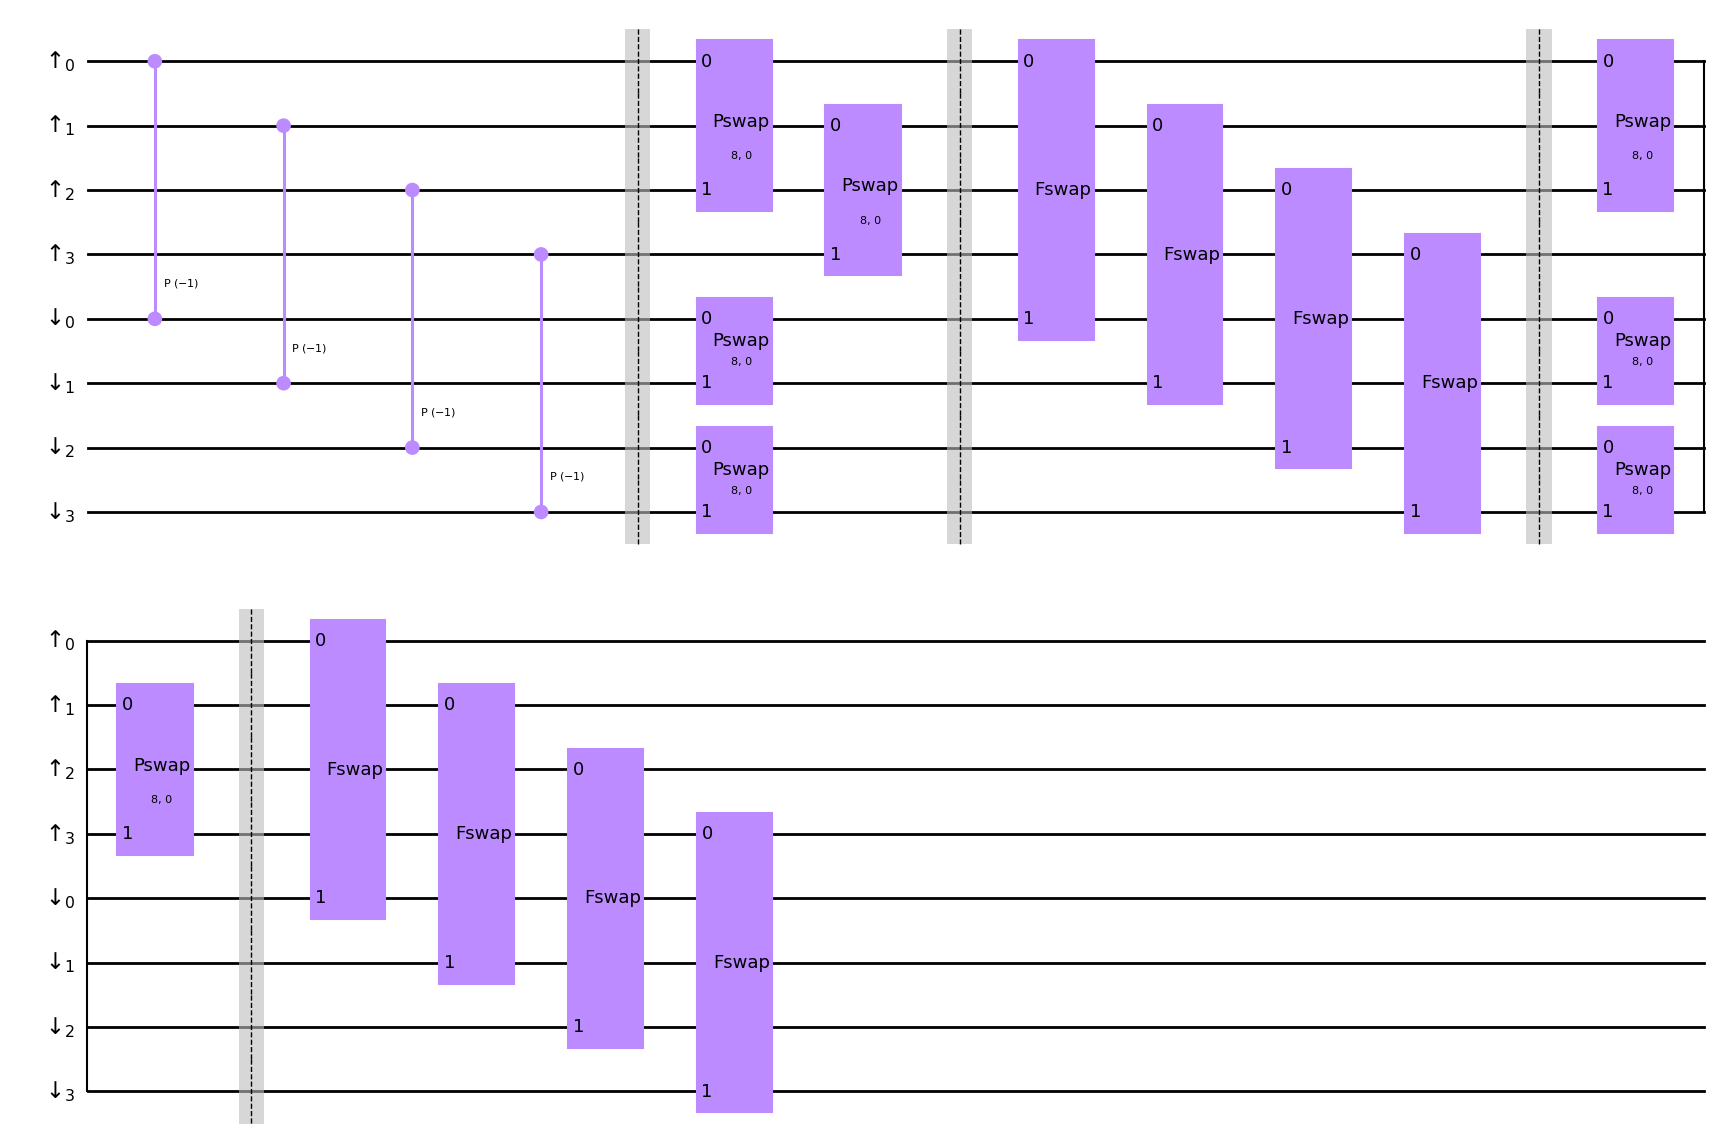

In [8]:
trotter_circuit.draw("mpl")

In [9]:
trotter_matrix = circuit2matrix(trotter_circuit, keep_qiskit_ordering=False)

In [10]:
print("Error: " + str(np.linalg.norm(ref_matrix - trotter_matrix, 2)))

Error: 3.947314014662047e-15


### Mapping

In [11]:
backend = WMIBackendGrid()

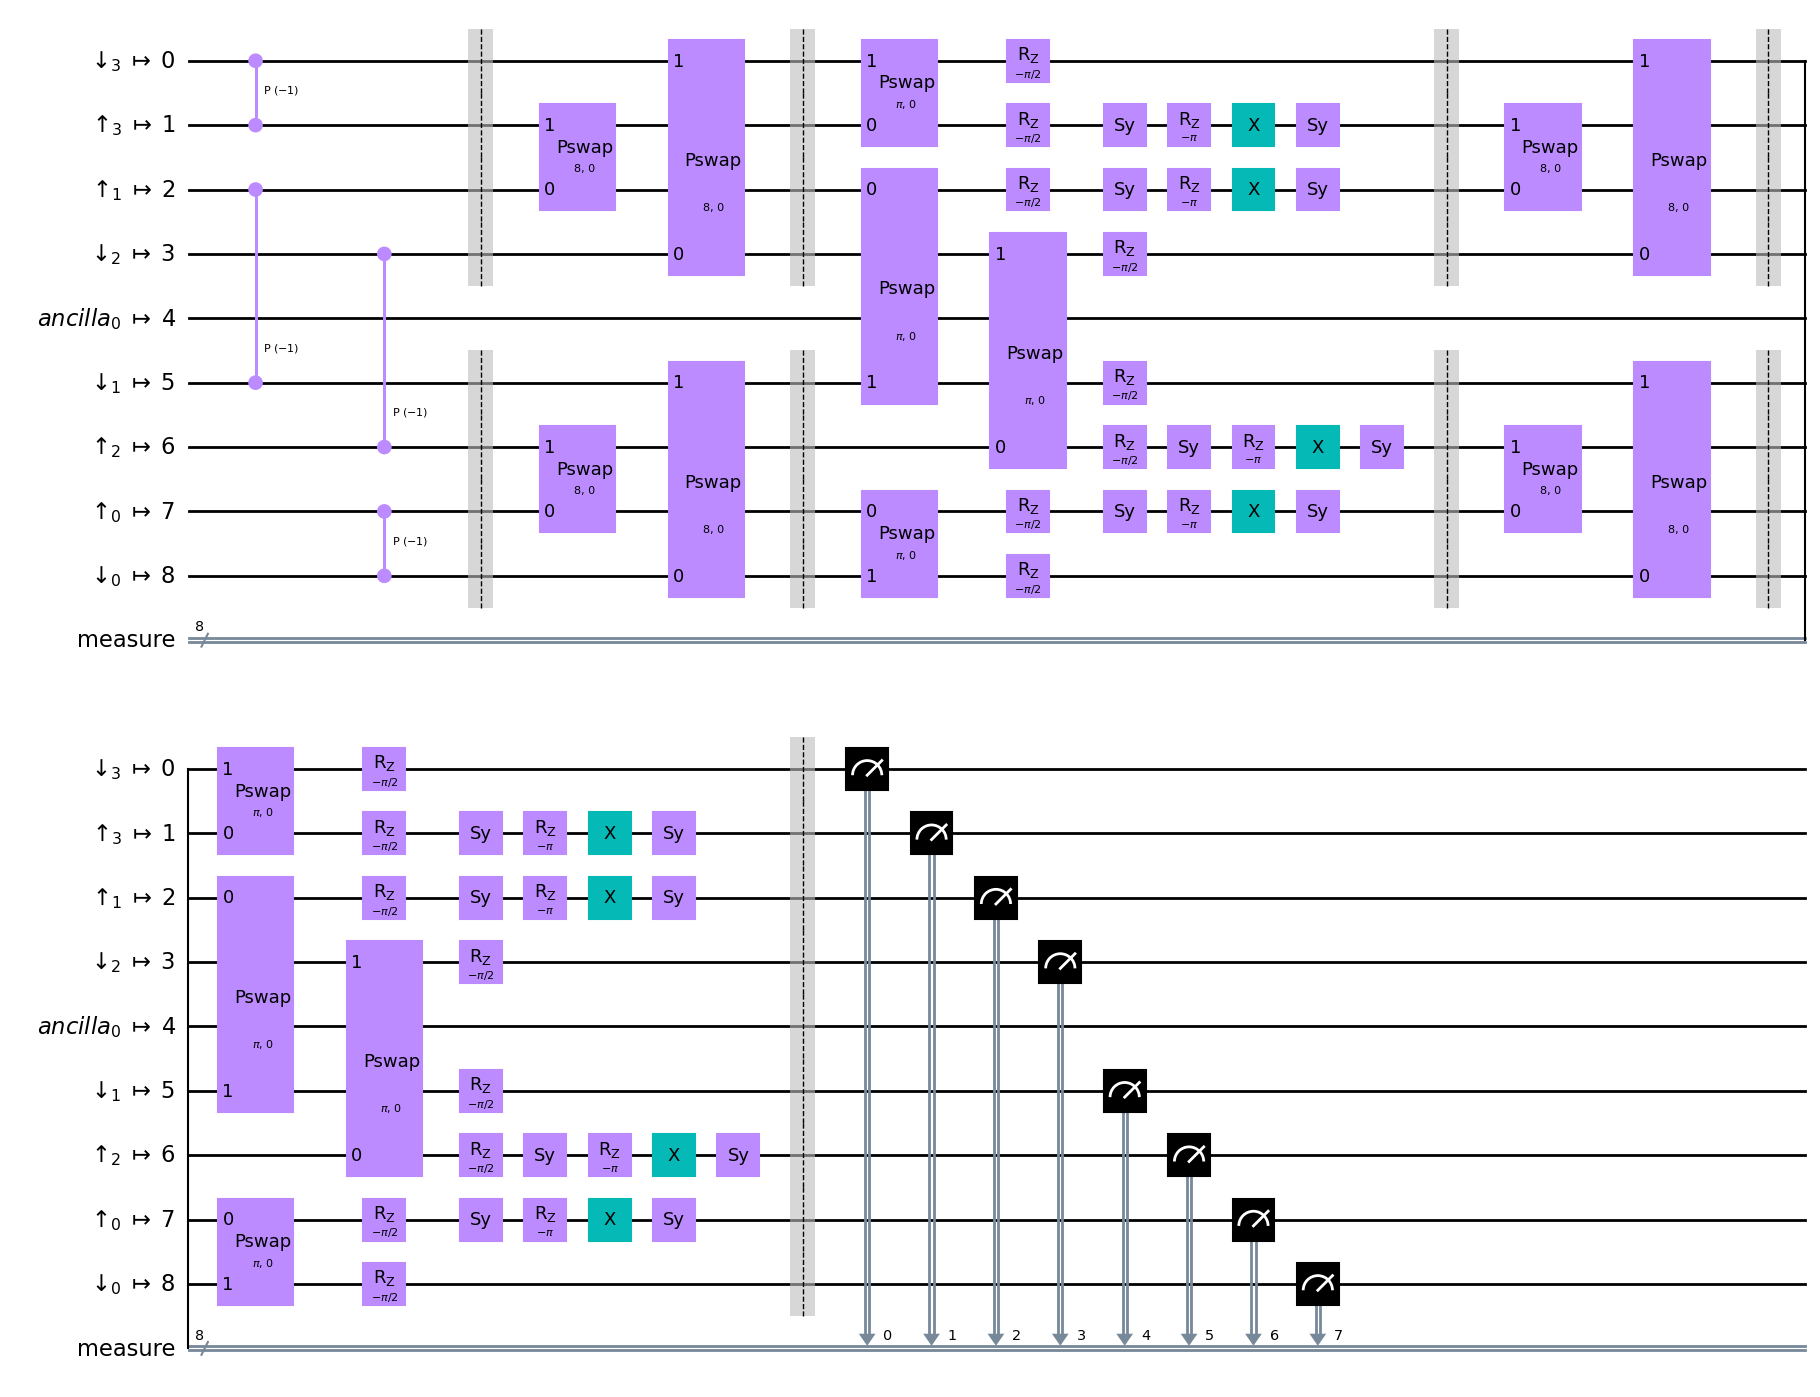

In [12]:
initial_layout = Layout({
    spin_up[0]:   0,
    spin_down[0]: 1,
    spin_up[1]:   2,
    spin_down[1]: 5,
    spin_up[2]:   3,
    spin_down[2]: 6,
    spin_up[3]:   7,
    spin_down[3]: 8,
})

# Transpile to WMI hardware
transpiled_circuit = transpile(
    trotter_circuit,
    backend=backend,
    optimization_level=3,
    #initial_layout=initial_layout
)
transpiled_circuit.measure_active()
transpiled_circuit.draw("mpl")

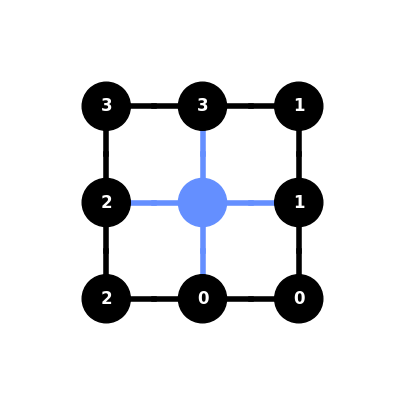

In [13]:
qubit_coordinates = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
plot_circuit_layout(transpiled_circuit, backend, view="virtual", qubit_coordinates=qubit_coordinates)